[[8.30030333 4.95375225]]
cpu usage		: 47.7 %
memory usage		: 0.14 %


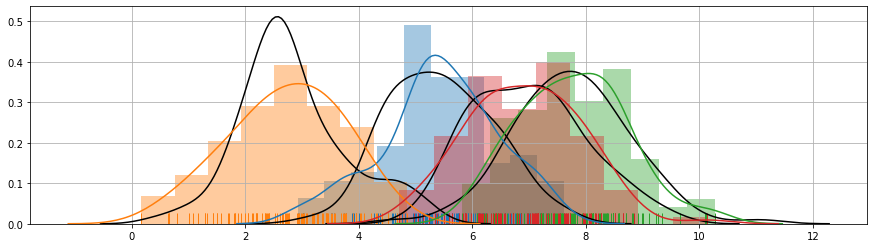

In [6]:
import numpy as np
from scipy import stats
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from openpyxl import Workbook
write_wb = Workbook()
write_ws = write_wb.active

class GMM(object):
    def __init__(self, X, k=1):
        # dimension
        X = np.asarray(X)
        self.m, self.n = X.shape
        self.data = X.copy()
        # number of mixtures
        self.k = k
        
    def _init(self):
        # init mixture means/sigmas
        self.mean_arr = np.asmatrix(np.random.random((self.k, self.n)))
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.w = np.asmatrix(np.empty((self.m, self.k), dtype=float))
        #print(self.mean_arr)
        #print(self.sigma_arr)
    
    def fit(self, tol=1e-4):
        self._init()
        num_iters = 0
        ll = 1
        previous_ll = 0
        while(ll-previous_ll > tol):
            previous_ll = self.loglikelihood()
            self._fit()
            num_iters += 1
            ll = self.loglikelihood()
            #print('Iteration %d: log-likelihood is %.6f'%(num_iters, ll))
        #print('Terminate at %d-th iteration:log-likelihood is %.6f'%(num_iters, ll))
    
    def loglikelihood(self):
        ll = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                #print(self.sigma_arr[j])
                tmp += sp.stats.multivariate_normal.pdf(self.data[i, :], 
                                                        self.mean_arr[j, :].A1, 
                                                        self.sigma_arr[j, :]) *\
                       self.phi[j]
            ll += np.log(tmp) 
        return ll
    
    def _fit(self):
        self.e_step()
        self.m_step()
        
    def e_step(self):
        # calculate w_j^{(i)}
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                num = sp.stats.multivariate_normal.pdf(self.data[i, :], 
                                                       self.mean_arr[j].A1, 
                                                       self.sigma_arr[j]) *\
                      self.phi[j]
                den += num
                self.w[i, j] = num
            self.w[i, :] /= den
            assert self.w[i, :].sum() - 1 < 1e-4
            
    def m_step(self):
        for j in range(self.k):
            const = self.w[:, j].sum()
            self.phi[j] = 1/self.m * const
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.w[i, j])
                _sigma_j += self.w[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
                #print((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = _sigma_j / const
            #print(self.mean_arr)
            
def tri(zd, H):
    zd = zd.T
    H=H-H[0]
    tmp = zd[0]
    tmp = tmp * tmp
    zd = np.delete(zd,(0), axis=0)
    r1=np.multiply(zd,zd)
    Ha=np.delete(H,(0), axis=0)
    K=np.multiply(Ha,Ha)
    K=K.sum(axis=1)
    b= 0.5*(K-r1+tmp) 
    S_inv = np.linalg.inv(Ha.T*Ha)*Ha.T
    x_hat = S_inv*b
    return x_hat

import os
import psutil

def _check_usage_of_cpu_and_memory():
    
    pid = os.getpid()
    py  = psutil.Process(pid)
    
    cpu_usage   = os.popen("ps aux | grep " + str(pid) + " | grep -v grep | awk '{print $3}'").read()
    cpu_usage   = cpu_usage.replace("\n","")
    
    memory_usage  = round(py.memory_info()[0] /2.**30, 2)
    
    print("cpu usage\t\t:", cpu_usage, "%")
    print("memory usage\t\t:", memory_usage, "%")

bias = 0
std = 0.5
cdf = np.random.random(100)

for j in range(0,1):
    x = np.array([7.54,4.8])
    #x = np.array([15*random.random(),15*random.random()])
    H = np.array([[7.54,0],[7.54,7.21],[14.14,0],[14.14,7.58]])
    H2 = np.matrix([[7.54,0],[7.54,7.21],[14.14,0],[14.14,7.58]])
    d = x-H
    d = np.multiply(d,d)
    d = np.sqrt(d.sum(axis=1))

    d_col_1 = d[0]
    d_col_2 = d[1] 
    d_col_3 = d[2]
    d_col_4 = d[3]
    real_arr = np.array([d_col_1,d_col_2,d_col_3,d_col_4])
    #print(real_arr)
    
    zd = np.matrix([d_col_1,d_col_2,d_col_3,d_col_4])
    #zd = np.matrix([[1.80995138,  3.48397144,  8.73081818, 10.20268591]])
    #zd = np.matrix([[3.64648334,  2.57997091, 11.32639935,  8.1178757 ]])
    #zd = np.matrix([6.41296919,2.12327138, 8.63384818, 7.80724504])
    x_hat = tri(zd,H2)
    x_hat = x_hat.T+H[0]
    #print(x_hat)

    SAMPLE = 100
    zd_col_tmp_1 = d[0] + np.random.normal(bias,std,1)
    zd_col_tmp_2 = d[1] + np.random.normal(bias,std,1)
    zd_col_tmp_3 = d[2] + np.random.normal(bias,std,1)
    zd_col_tmp_4 = d[3] + np.random.normal(bias,std,1)
    X1 = zd_col_tmp_1 
    X2 = zd_col_tmp_2
    X3 = zd_col_tmp_3
    X4 = zd_col_tmp_4
    zd = np.matrix([zd_col_tmp_1,zd_col_tmp_2,zd_col_tmp_3,zd_col_tmp_4])
    #x_hat = tri(zd,H2)
    #x_hat = x_hat.T+H[0]
    #print(x_hat)

    X = np.array([zd_col_tmp_1,zd_col_tmp_2,zd_col_tmp_3,zd_col_tmp_4])

    #X = np.array([3.48167247, 0.22088919, 8.05513094, 5.6887382])
    #print(X)

    zd_col_1 = zd_col_tmp_1 + np.random.normal(0,1,SAMPLE-1)
    zd_col_2 = zd_col_tmp_2 + np.random.normal(0,1,SAMPLE-1)
    zd_col_3 = zd_col_tmp_3 + np.random.normal(0,1,SAMPLE-1)
    zd_col_4 = zd_col_tmp_4 + np.random.normal(0,1,SAMPLE-1)
    mu_arr = np.array([zd_col_1,zd_col_2,zd_col_3,zd_col_4])
    X = np.append(X,mu_arr,axis = 1)
    X1 = np.append(X1,zd_col_1)
    X2 = np.append(X2,zd_col_2)
    X3 = np.append(X3,zd_col_3)
    X4 = np.append(X4,zd_col_4)
    X_rev = np.transpose(X)
    
    #print(X_rev)

    #X = np.random.multivariate_normal([0, 3], [[0.5, 0], [0, 0.8]], 20)
    #X = np.vstack((X, np.random.multivariate_normal([20, 10], np.identity(2), 50)))
    #X.shape
    t = range(0,SAMPLE)

    gmm = GMM(X_rev)
    gmm.fit()
    dist_1 = gmm.mean_arr[0,0]
    dist_2 = gmm.mean_arr[0,1]
    dist_3 = gmm.mean_arr[0,2]
    dist_4 = gmm.mean_arr[0,3]
    zd = np.matrix([dist_1,dist_2,dist_3,dist_4])
    x_hat = tri(zd,H2)
    x_hat = x_hat.T+H[0]
    print(x_hat)
    #print(gmm.mean_arr)
    dev = np.multiply((x_hat-x),(x_hat-x))
    tmp = dev.item(0)+dev.item(1)
    res = np.sqrt(tmp)
    cdf[j] = res
    j = j + 1

    dev = np.multiply((x_hat-x),(x_hat-x))
    tmp = dev.item(0)+dev.item(1)
    res = np.sqrt(tmp)
    #write_ws['A1'] = 'Deviation'
    #write_ws.cell(j+2,1,res)
    #write_wb.save('/Users/swbaek/Desktop/em.xlsx')#('/Users/swbaek/Desktop/deviation.xlsx')

_check_usage_of_cpu_and_memory()
#print("time :", time.time() - start)
fig, ax = plt.subplots(figsize=(15, 4))
plt.grid()
sns.distplot(np.random.normal(gmm.mean_arr[[0],[0]], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(np.random.normal(gmm.mean_arr[[0],[1]], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(np.random.normal(gmm.mean_arr[[0],[2]], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(np.random.normal(gmm.mean_arr[[0],[3]], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(X1, ax=ax, rug=True)
sns.distplot(X2, ax=ax, rug=True)
sns.distplot(X3, ax=ax, rug=True)
sns.distplot(X4, ax=ax, rug=True)

In [11]:
X_rev[range(0,SAMPLE)][0]

array([6.71983125, 6.54210089, 6.4610155 , 8.20932715])

In [105]:
print(gmm.mean_arr[0,0])

4.763750551053947


In [10]:
print(X)

[[14.70088271 16.52809158 13.64371791 16.44714154 15.03922523 13.97131758
  14.09870135 14.19392783 13.47217154 14.42400325 15.0527051  14.83411835
  15.24583546 14.31641119 14.85820279 15.54124993 14.35787825 14.56799405
  14.37192044 14.00555771 14.4612513  15.37613782 14.09119828 14.76628327
  15.26583363 14.43233465 12.87835568 16.69595403 13.78488211 14.02196621
  16.27403643 14.67148998 16.41714668 15.42597547 14.94772907 15.7239834
  15.3569755  14.11586077 15.52734332 13.01919093 15.80853048 13.8487813
  16.61182806 13.71278981 15.84342352 15.3359181  15.39052377 13.83799275
  15.02943486 14.42442074 15.50398166 14.57653542 14.13080484 13.79206794
  14.43442942 14.00503956 14.9747637  15.03214867 15.66191622 13.8269827
  14.90713374 15.8643315  12.94454404 16.36825416 16.12368106 13.84770458
  15.43071114 15.25917053 14.01542511 14.49435581 15.57985262 13.04062189
  15.91511805 13.0598608  15.72589104 14.15786273 14.6036836  15.00015952
  14.45444505 15.00978912 14.35519228 13.

In [10]:
print(x_hat[1])

IndexError: index 1 is out of bounds for axis 0 with size 1